In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import stats
from scipy.stats import probplot, skew, kurtosis

In [2]:
df = pd.read_csv("tip.csv")

In [4]:
# Information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [7]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


Here's a description of each column in the dataset:

total_bill: The total bill amount, including the cost of food and drinks.

tip: The tip amount given by the customer.

sex: The gender of the customer (e.g., Male or Female).

smoker: Whether the customer is a smoker or not (e.g., Yes or No).

day: The day of the week when the transaction occurred (e.g., Sun, Sat, Thu, etc.).

time: The time of day when the transaction occurred, typically categorized as Lunch or Dinner.

size: The size of the party or group of customers.

#### Data Visualisation 

<Axes: xlabel='total_bill', ylabel='tip'>

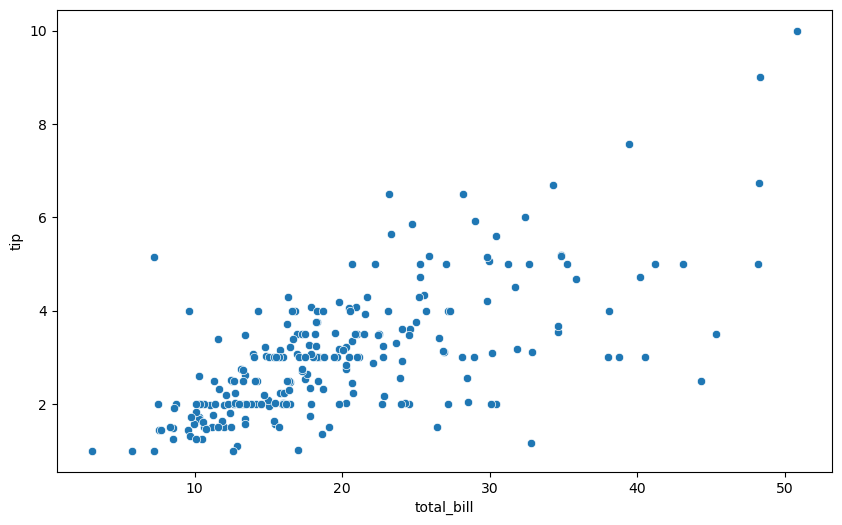

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='total_bill', y='tip')

<Axes: >

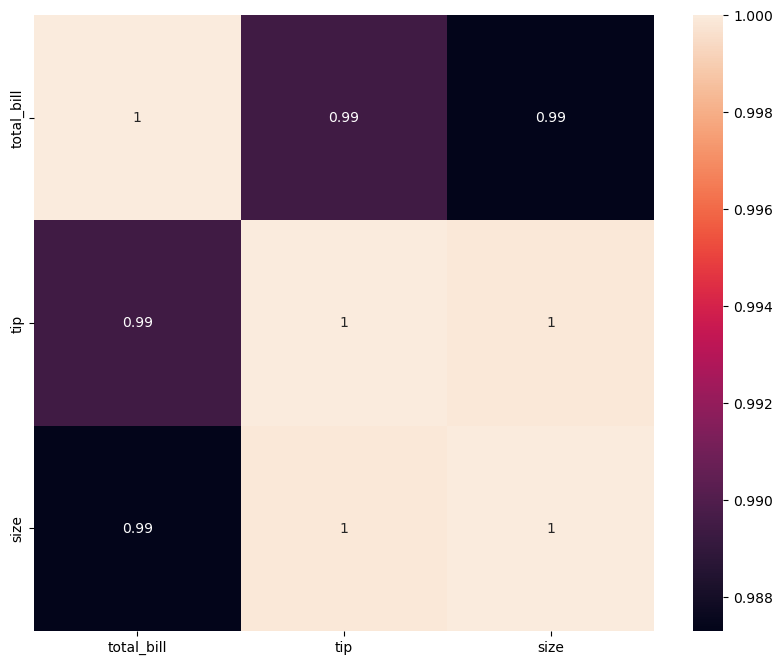

In [13]:
corr_matrix = df.describe().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)


Text(0.5, 1.09, 'Pair Plot of Numerical Features')

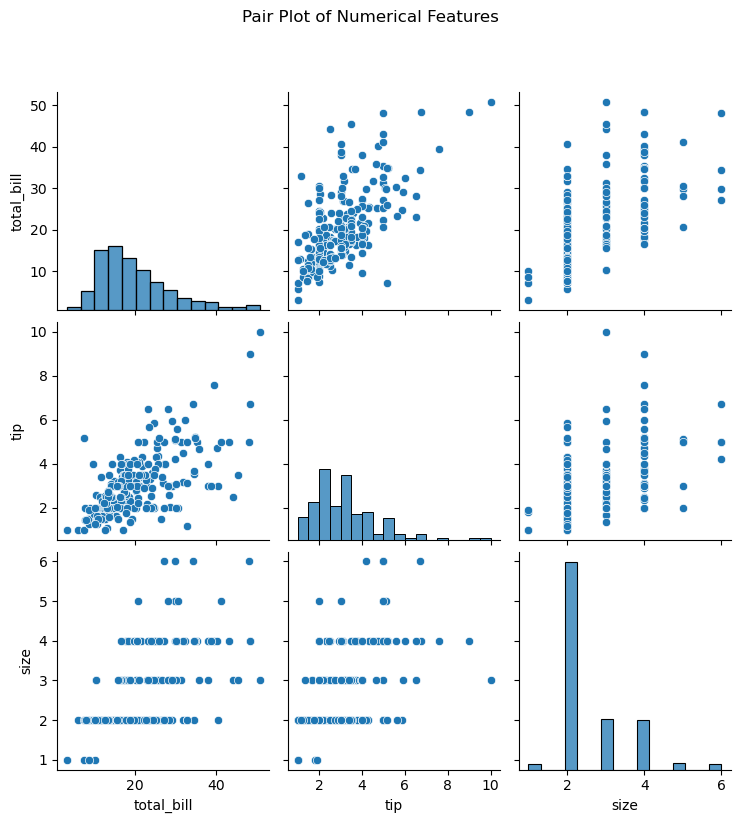

In [15]:
sns.pairplot(df, vars=['total_bill', 'tip', 'size'])
plt.suptitle('Pair Plot of Numerical Features', y=1.09)

<Axes: xlabel='time', ylabel='tip'>

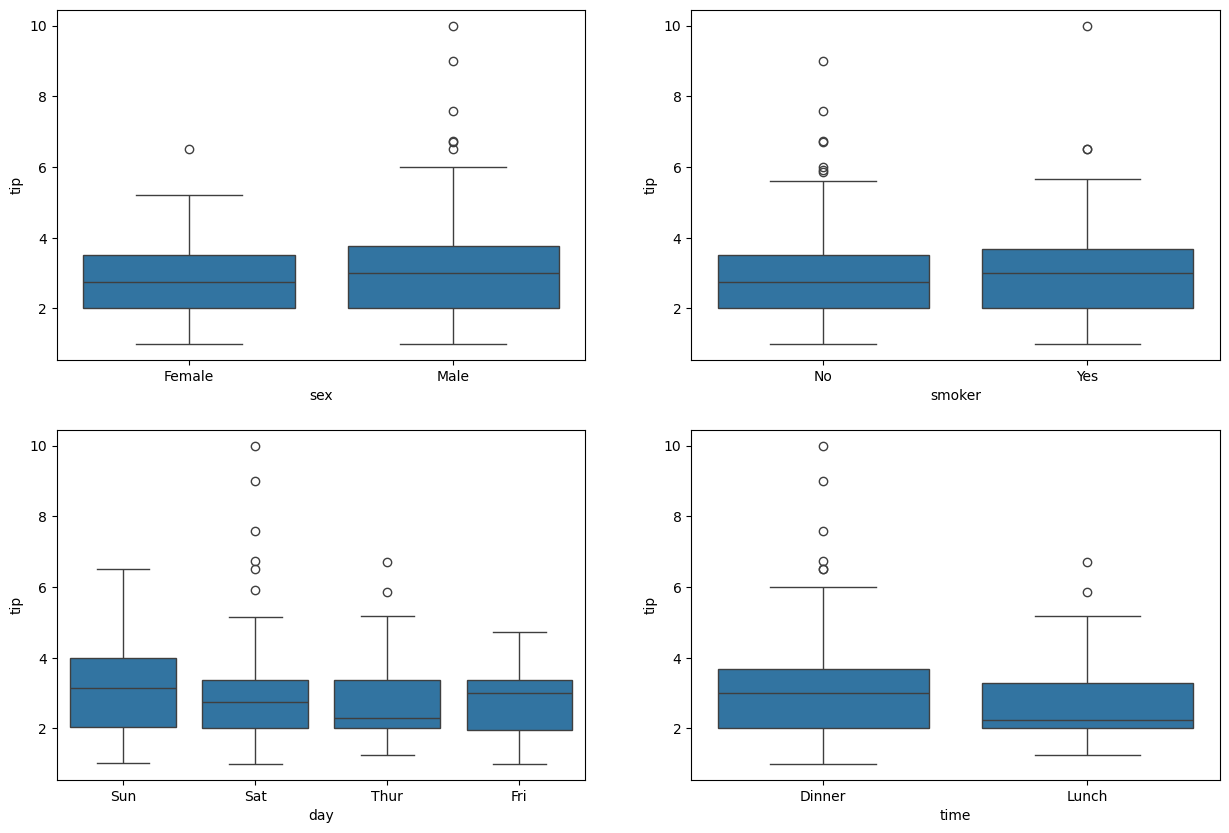

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(data=df, x='sex', y='tip', ax=axes[0, 0])
sns.boxplot(data=df, x='smoker', y='tip', ax=axes[0, 1])
sns.boxplot(data=df, x='day', y='tip', ax=axes[1, 0])
sns.boxplot(data=df, x='time', y='tip', ax=axes[1, 1])

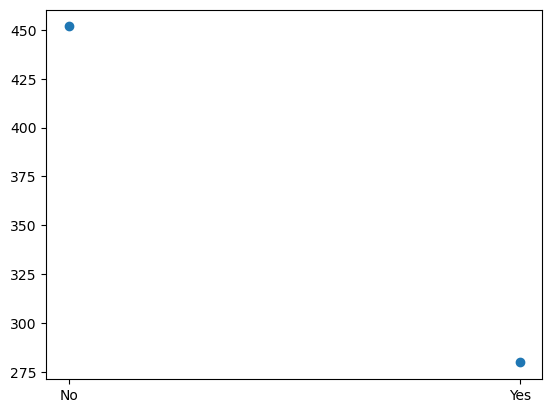

In [19]:
# Checking the day vs smoker columns
data = df.groupby(by = "smoker")["tip"].sum()
plt.scatter(data.index, data.values)

## Data PreProcessing

In [23]:
X = df.drop('tip', axis=1)
y = df['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numeric_features = ['total_bill', 'size']
categorical_features = ['sex', 'smoker', 'day', 'time']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

In [25]:
def assess_model(performance_model, label):
    # Constructing the processing pipeline
    processing_pipeline = Pipeline([
        ('data_preparation', preprocessor),
        ('estimator', performance_model)
    ])
    
    # Model fitting and generating predictions
    processing_pipeline.fit(X_train, y_train)
    test_predictions = processing_pipeline.predict(X_test)
    
    # Calculating error metrics
    mean_squared_err = mean_squared_error(y_test, test_predictions)
    root_mean_squared_err = np.sqrt(mean_squared_err)
    r_squared_value = r2_score(y_test, test_predictions)
    
    # Performing cross-validation
    validation_scores = cross_val_score(processing_pipeline, X, y, cv=5, scoring='r2')
    
    print(f"\n{label} Performance:")
    print(f"Root Mean Squared Error (RMSE): {root_mean_squared_err:.4f}")
    print(f"R-squared Score: {r_squared_value:.4f}")
    print(f"Cross-Validation R2: Mean={validation_scores.mean():.4f}, Std Dev={validation_scores.std() * 2:.4f}")
    
    return processing_pipeline, root_mean_squared_err, r_squared_value

# Define different models to be tested
model_catalog = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.1),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Support Vector Machine (SVR)': SVR(kernel='rbf'),
    'K-Nearest Neighbor Regressor': KNeighborsRegressor(n_neighbors=5)
}

# Collect model evaluation results
model_performance_summary = {}
for model_label, estimator in model_catalog.items():
    trained_pipeline, rmse_value, r2_value = assess_model(estimator, model_label)
    model_performance_summary[model_label] = {'Root Mean Squared Error': rmse_value, 'R-squared': r2_value}



Linear Regression Performance:
Root Mean Squared Error (RMSE): 0.8387
R-squared Score: 0.4373
Cross-Validation R2: Mean=0.4215, Std Dev=0.2706

Ridge Regression Performance:
Root Mean Squared Error (RMSE): 0.8385
R-squared Score: 0.4375
Cross-Validation R2: Mean=0.4217, Std Dev=0.2702

Lasso Regression Performance:
Root Mean Squared Error (RMSE): 0.7824
R-squared Score: 0.5102
Cross-Validation R2: Mean=0.4573, Std Dev=0.2166

Decision Tree Regressor Performance:
Root Mean Squared Error (RMSE): 1.1204
R-squared Score: -0.0042
Cross-Validation R2: Mean=0.1043, Std Dev=0.3286

Random Forest Regressor Performance:
Root Mean Squared Error (RMSE): 0.9582
R-squared Score: 0.2654
Cross-Validation R2: Mean=0.4015, Std Dev=0.2425

Support Vector Machine (SVR) Performance:
Root Mean Squared Error (RMSE): 0.8423
R-squared Score: 0.4324
Cross-Validation R2: Mean=0.4049, Std Dev=0.2603

K-Nearest Neighbor Regressor Performance:
Root Mean Squared Error (RMSE): 0.8971
R-squared Score: 0.3561
Cross-Va

### Thus, we can see that the linear models perform good and in those too, the ridge regression is performing the best with and R2 Score of 0.4375

## Feature importance analysis using random forests

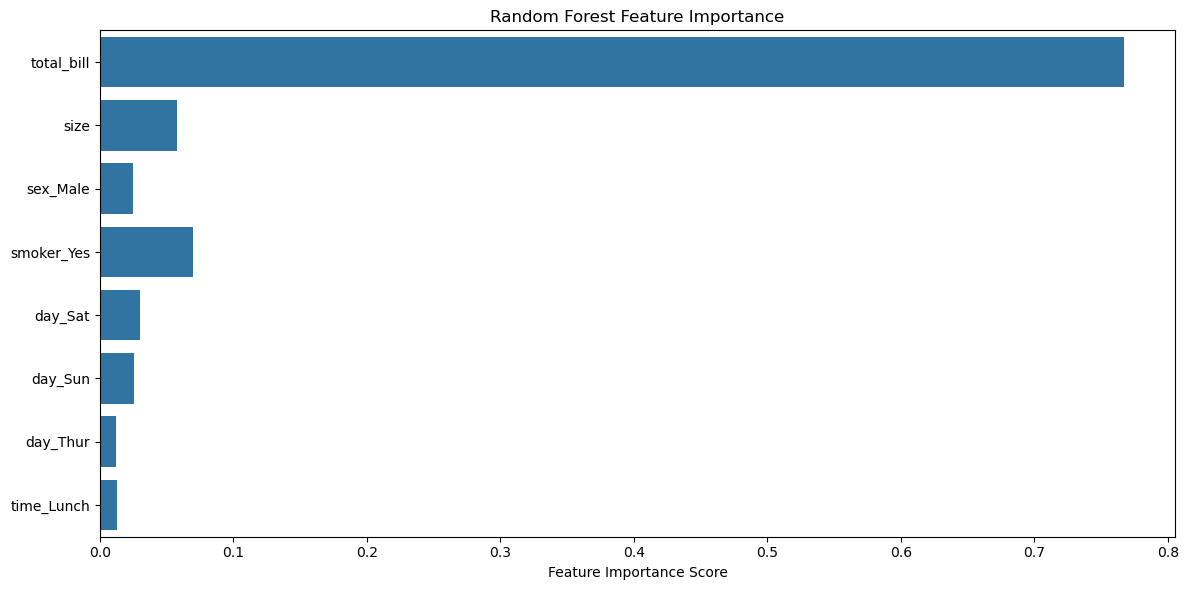

In [28]:
# Set up pipeline with preprocessor and RandomForest regressor
random_forest_pipeline = Pipeline([
    ('data_transformer', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])
random_forest_pipeline.fit(X_train, y_train)

# Retrieve feature names post-preprocessing
processed_feature_names = (
    numeric_features +
    [f"{category}_{level}" for category, levels in 
     zip(categorical_features, 
         preprocessor.named_transformers_['cat'].categories_) 
     for level in levels[1:]]
)

# Extract feature importances
feature_importance_values = random_forest_pipeline.named_steps['model'].feature_importances_

# Visualize feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance_values, y=processed_feature_names)
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()


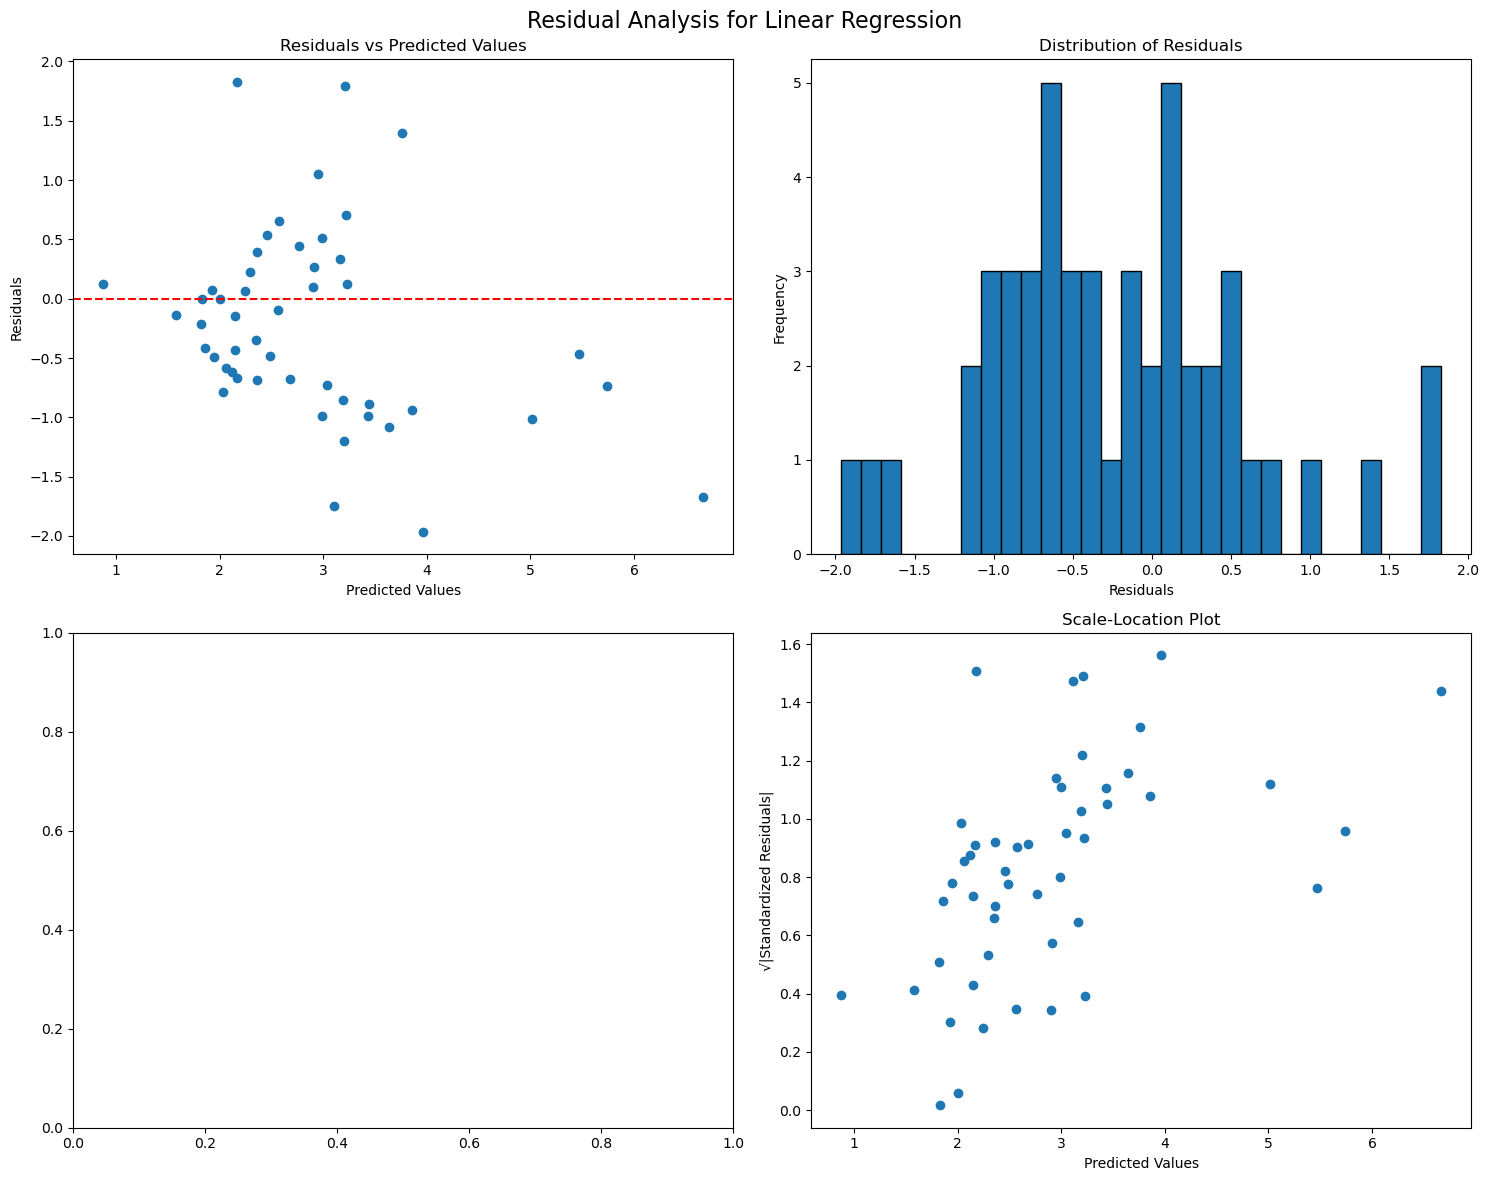


Model Performance for Linear Regression:
Root Mean Squared Error (RMSE): 0.8387
R2 Score: 0.4373
Cross-Validation R2 Score: Mean = 0.4215, Std Dev = 0.2706


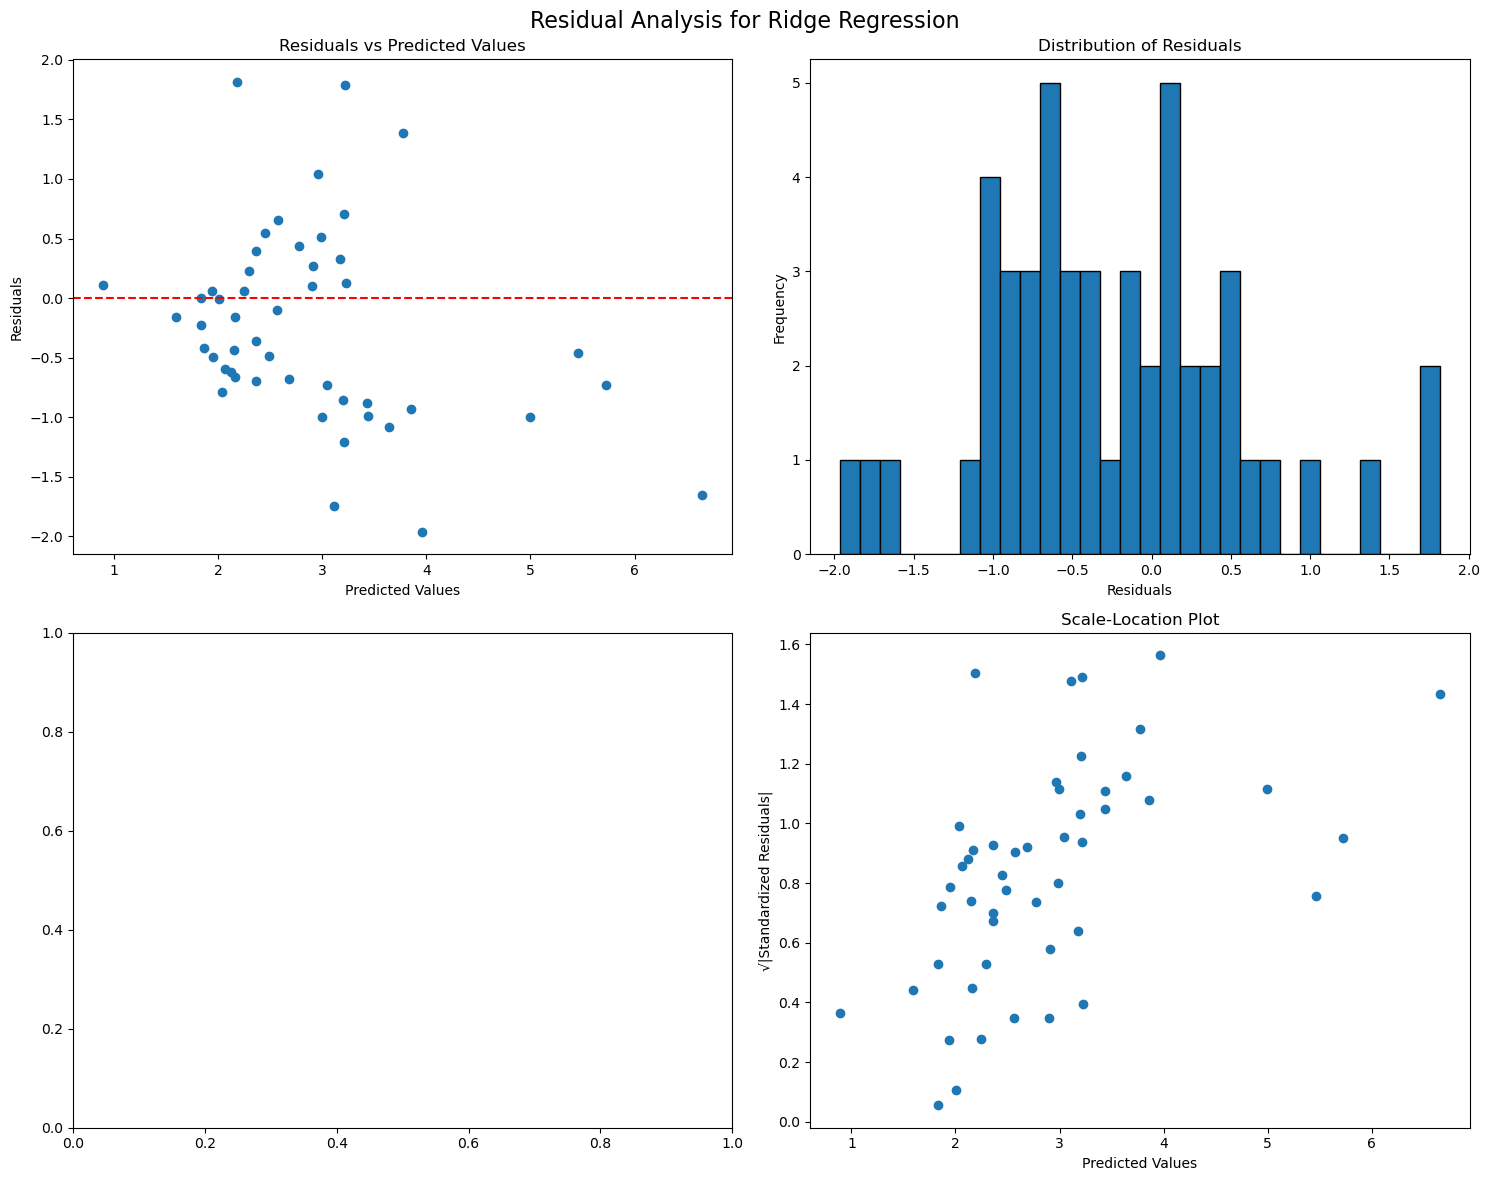


Model Performance for Ridge Regression:
Root Mean Squared Error (RMSE): 0.8370
R2 Score: 0.4395
Cross-Validation R2 Score: Mean = 0.4231, Std Dev = 0.2668


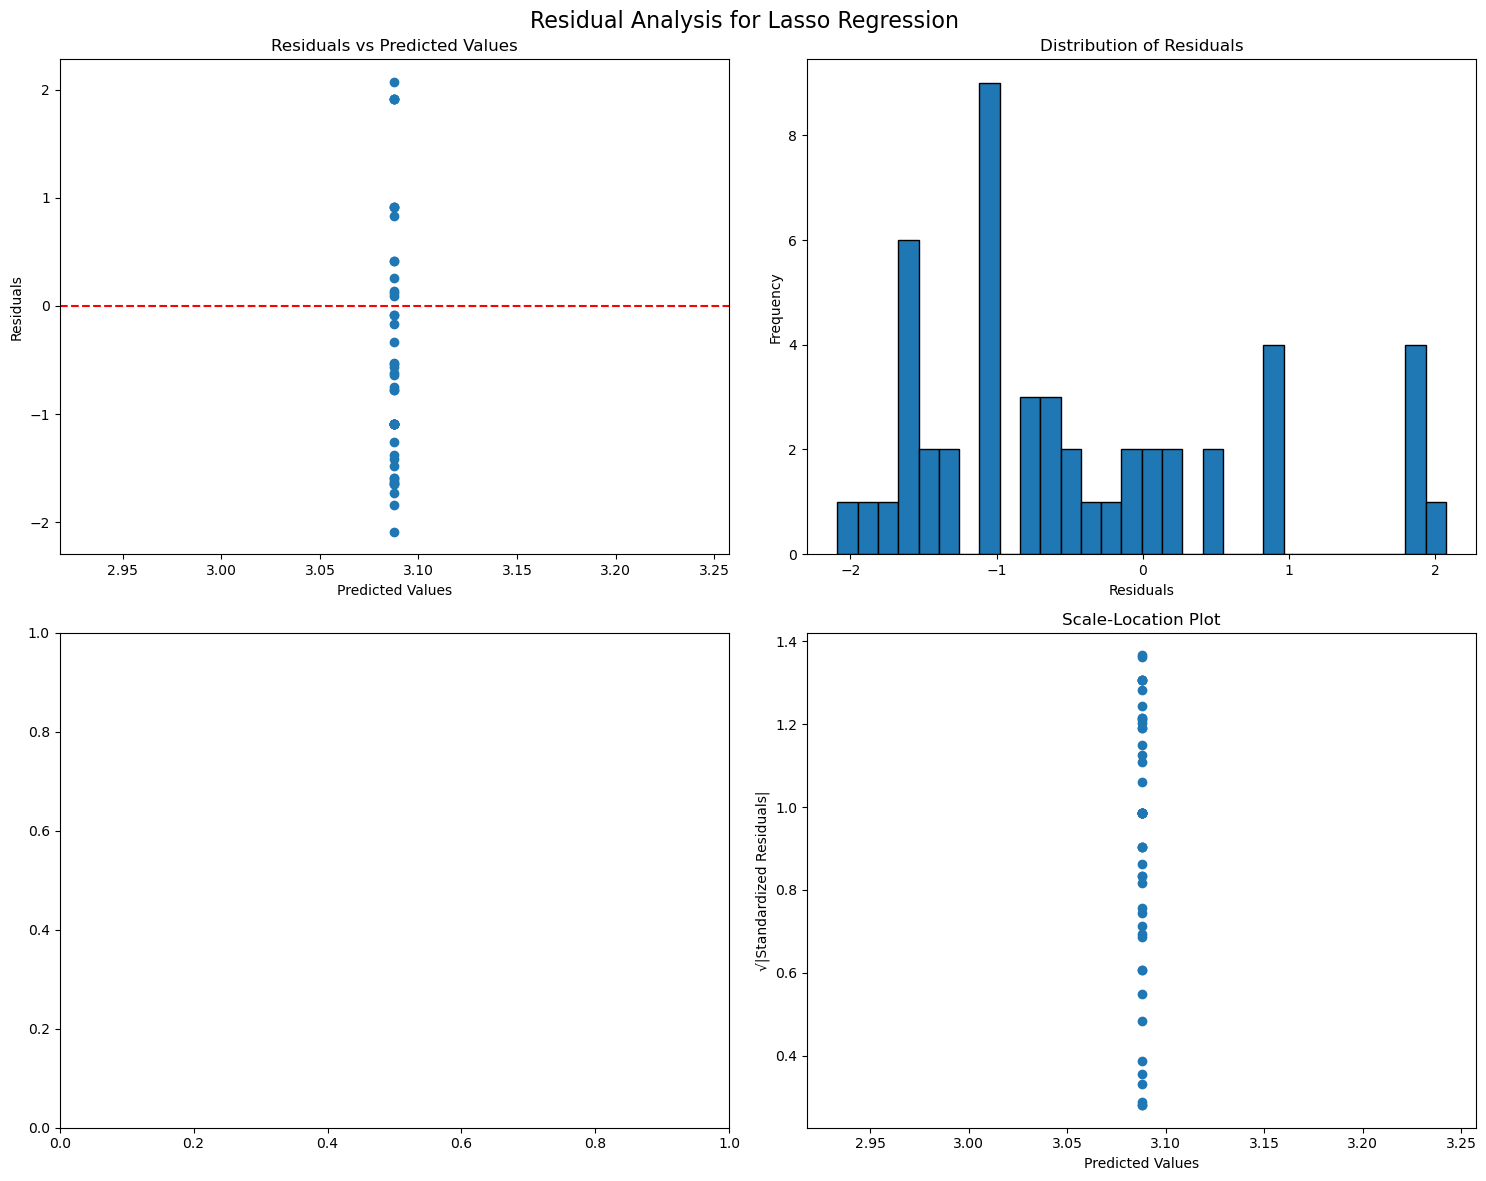


Model Performance for Lasso Regression:
Root Mean Squared Error (RMSE): 1.2036
R2 Score: -0.1590
Cross-Validation R2 Score: Mean = -0.0231, Std Dev = 0.0334


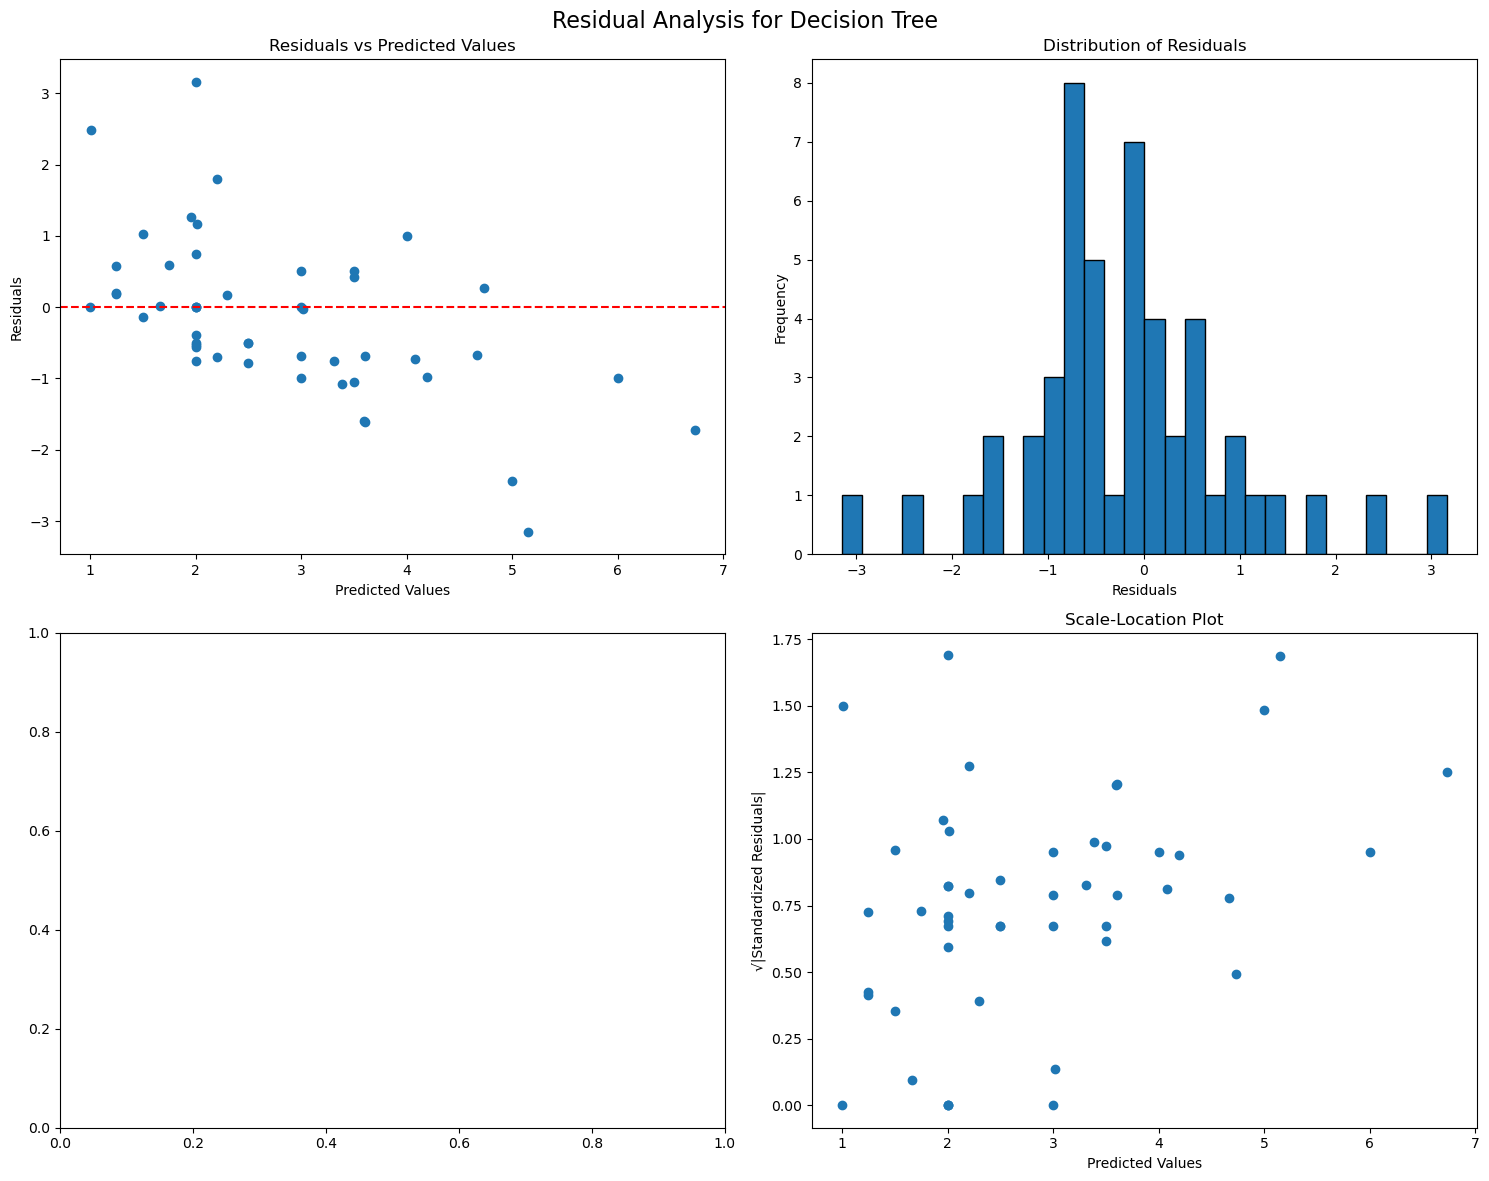


Model Performance for Decision Tree:
Root Mean Squared Error (RMSE): 1.1204
R2 Score: -0.0042
Cross-Validation R2 Score: Mean = 0.1043, Std Dev = 0.3286


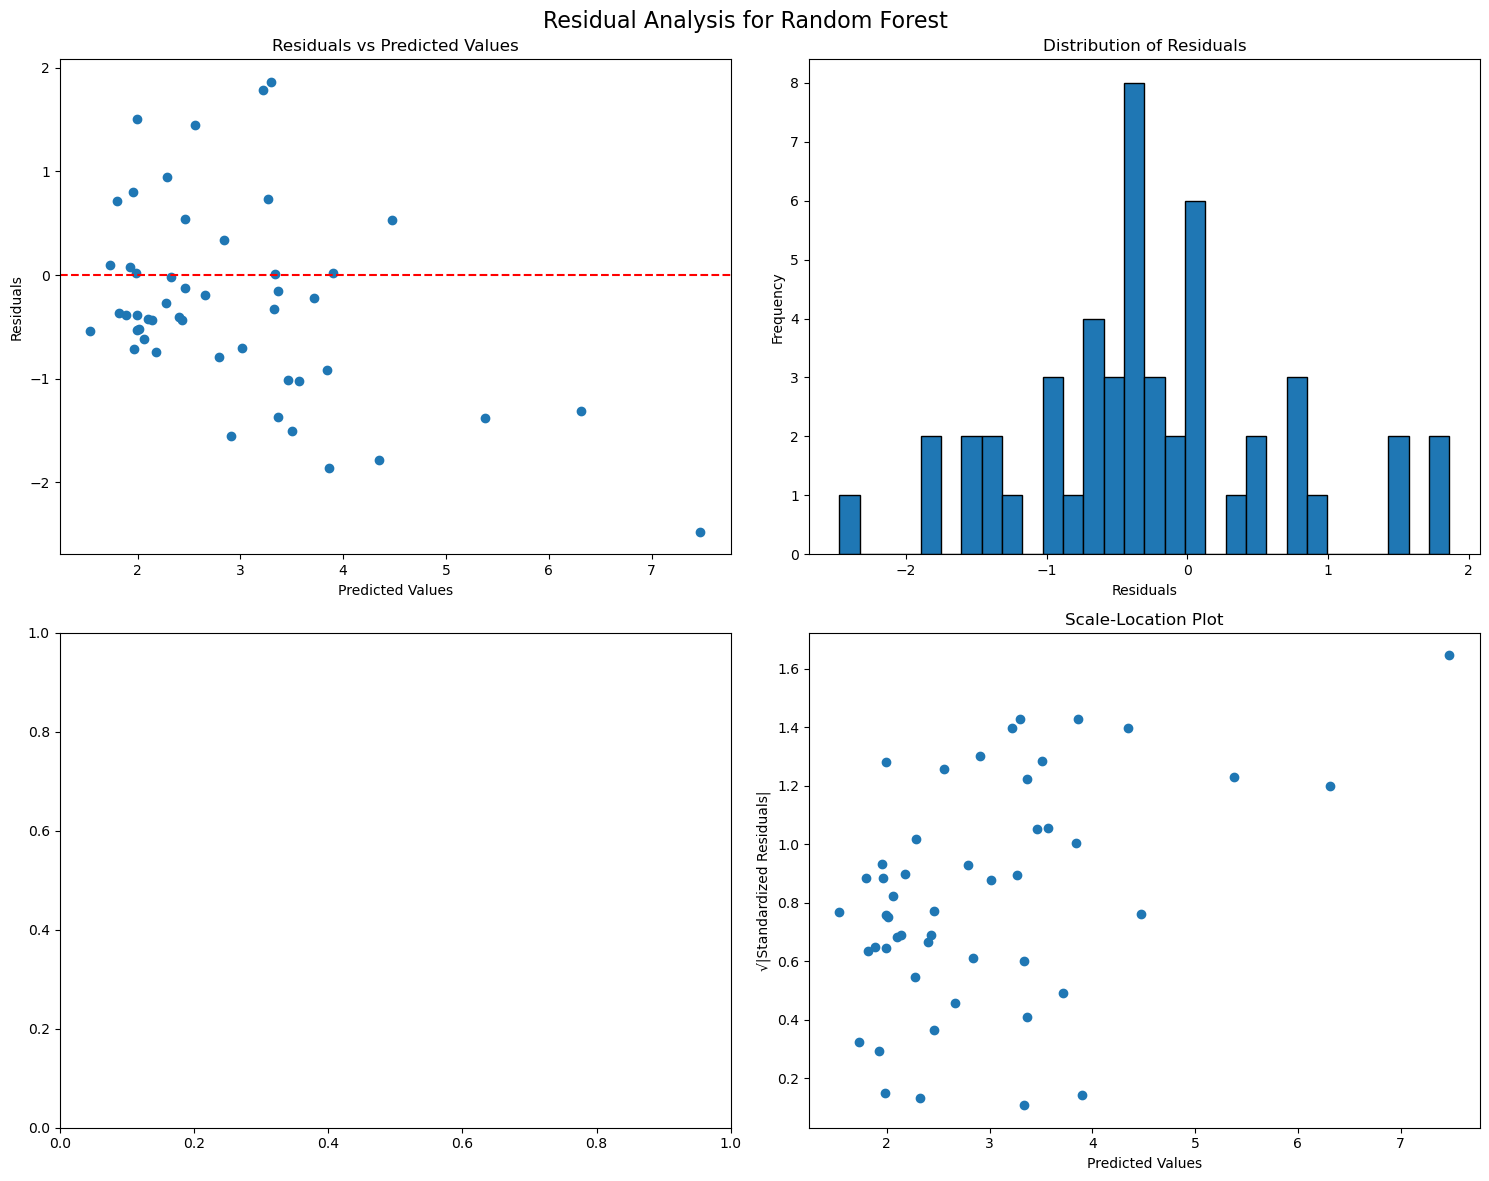


Model Performance for Random Forest:
Root Mean Squared Error (RMSE): 0.9582
R2 Score: 0.2654
Cross-Validation R2 Score: Mean = 0.4015, Std Dev = 0.2425


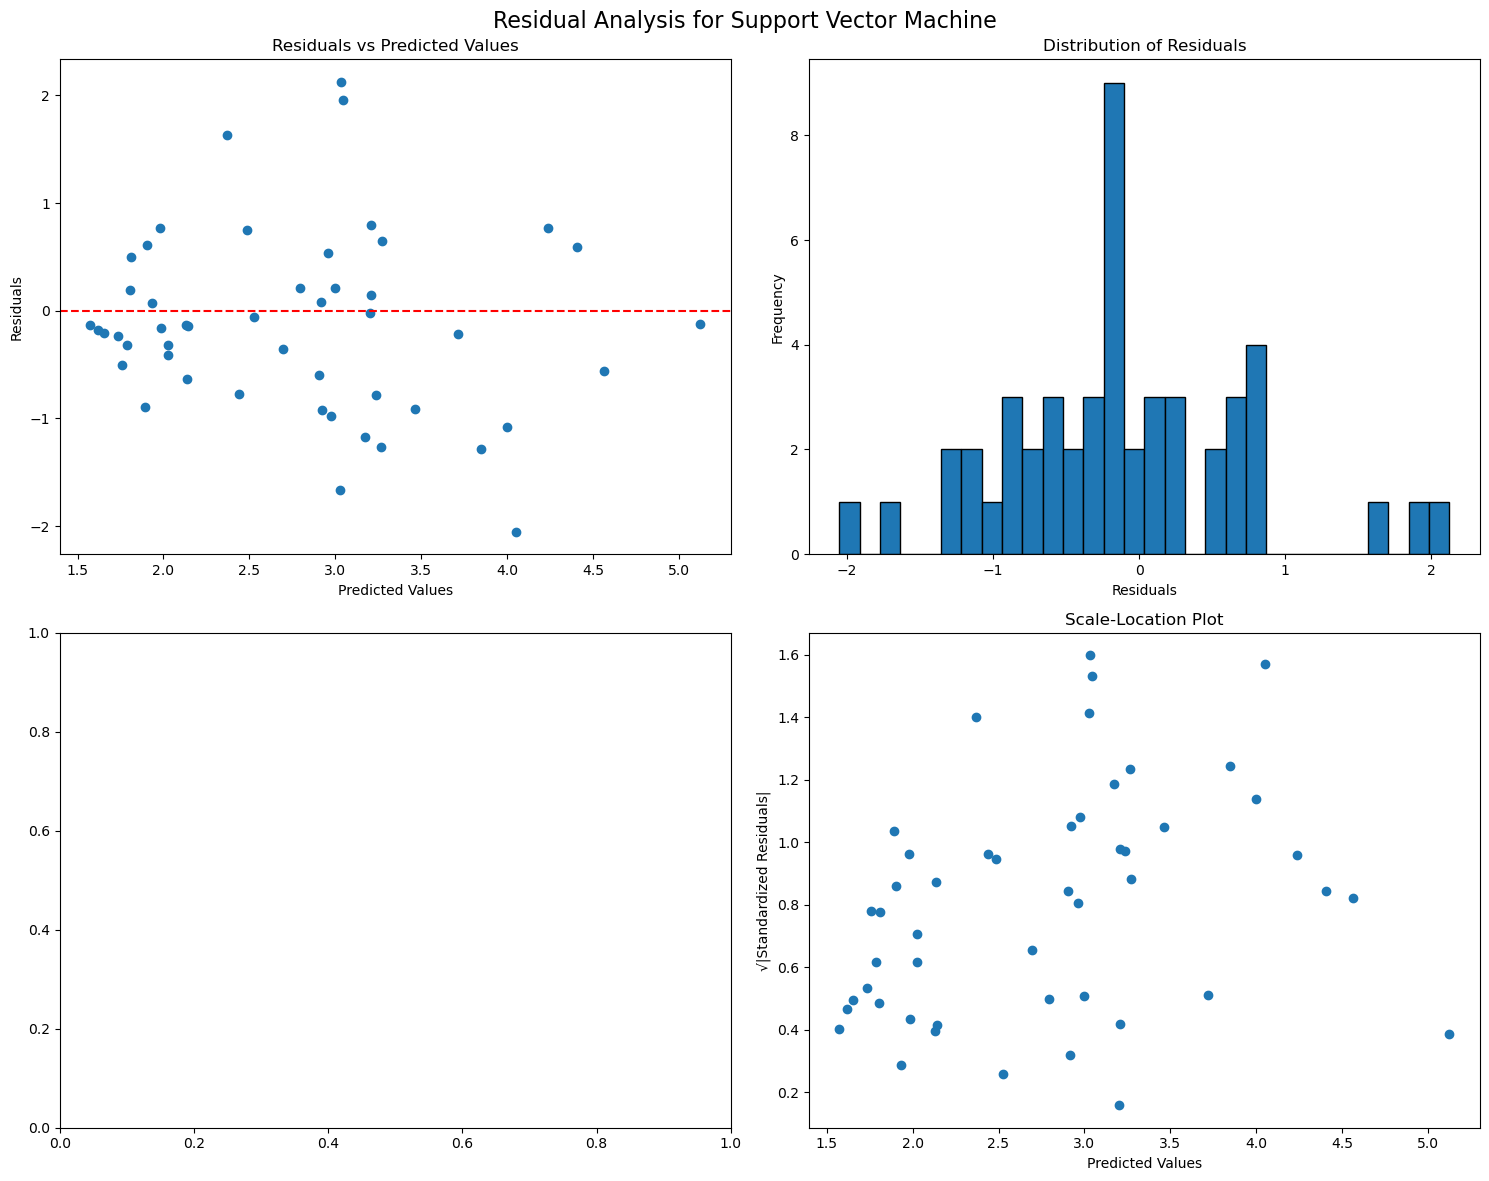


Model Performance for Support Vector Machine:
Root Mean Squared Error (RMSE): 0.8423
R2 Score: 0.4324
Cross-Validation R2 Score: Mean = 0.4049, Std Dev = 0.2603


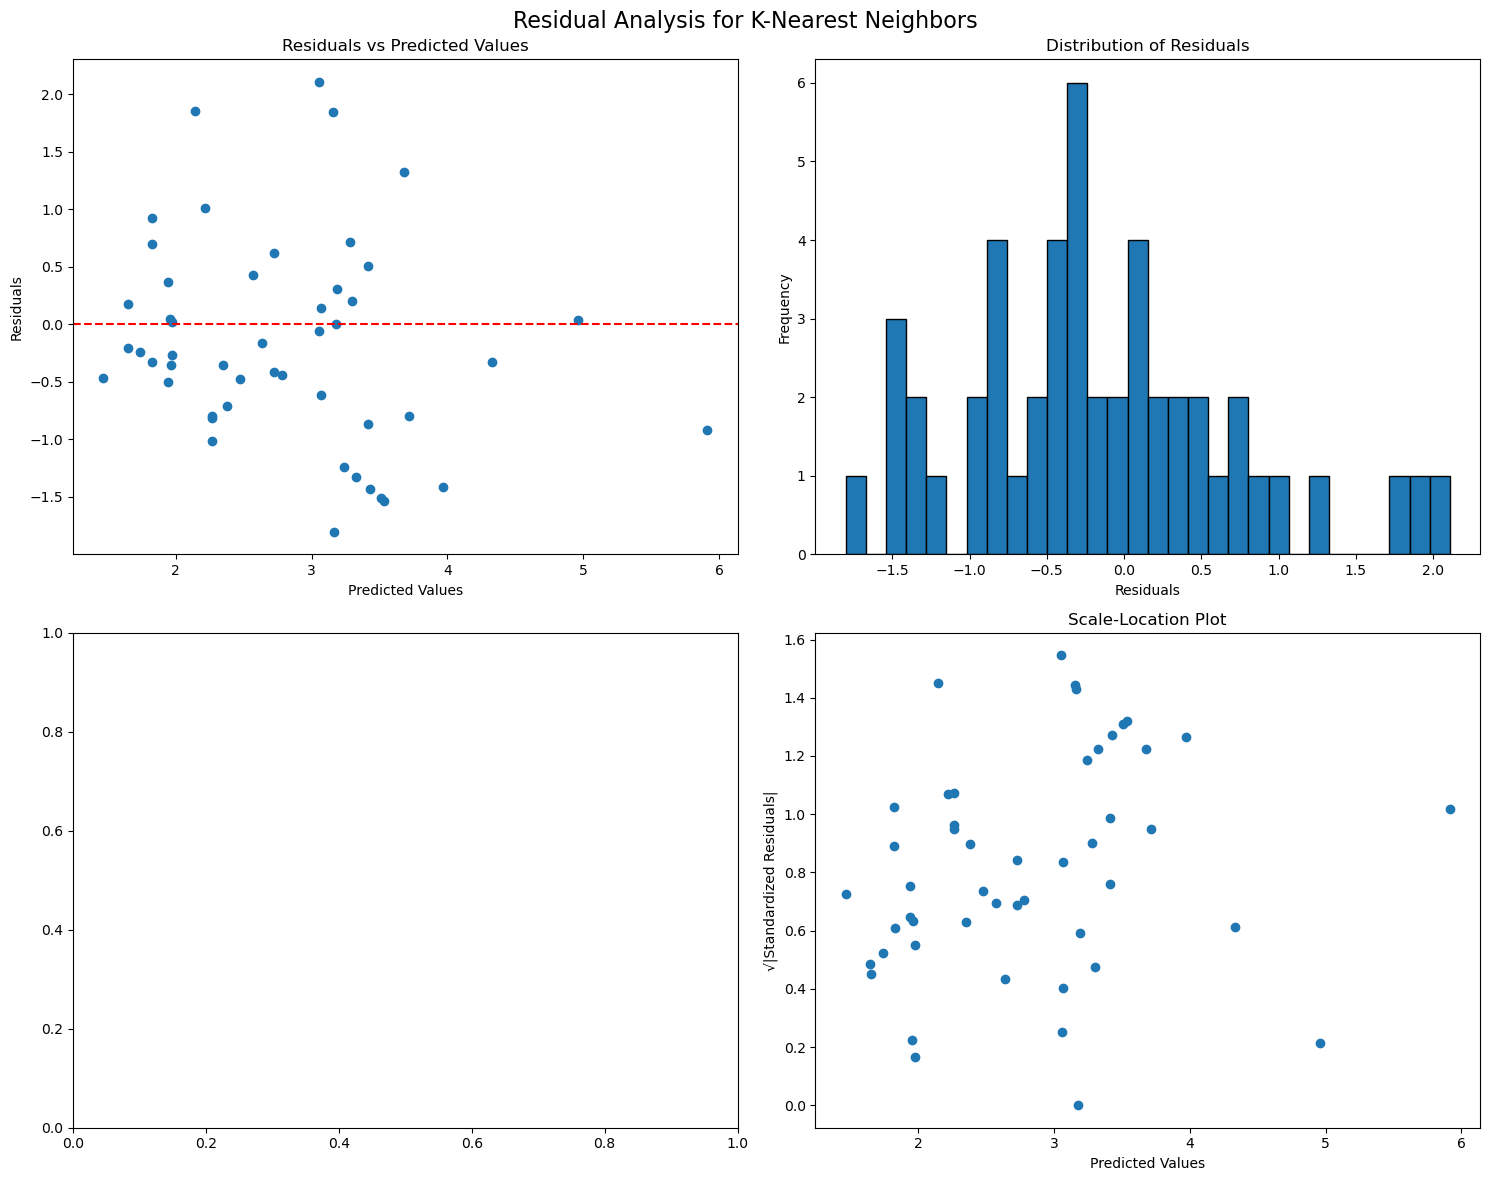


Model Performance for K-Nearest Neighbors:
Root Mean Squared Error (RMSE): 0.8971
R2 Score: 0.3561
Cross-Validation R2 Score: Mean = 0.3378, Std Dev = 0.1663


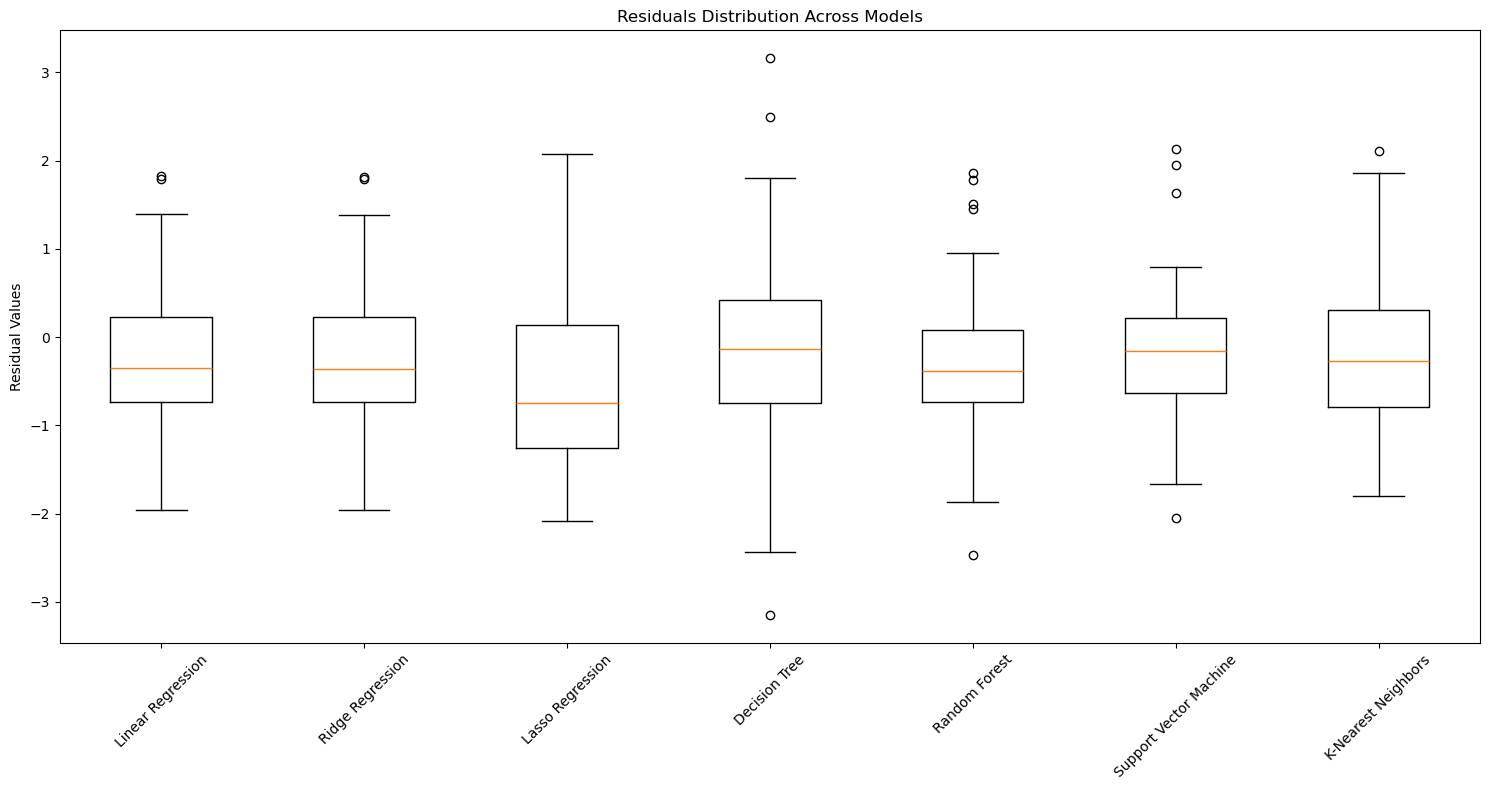


Summary of Residual Statistics Across Models:
                    Model    Mean  Standard Deviation
0       Linear Regression -0.2330              0.8056
1        Ridge Regression -0.2361              0.8031
2        Lasso Regression -0.4458              1.1180
3           Decision Tree -0.1729              1.1069
4           Random Forest -0.2866              0.9144
5  Support Vector Machine -0.1324              0.8319
6     K-Nearest Neighbors -0.1636              0.8821


In [46]:
def analyze_model_residuals(regression_model, model_label):
    # Define pipeline for preprocessing and regression model
    model_pipeline = Pipeline([
        ('data_processing', preprocessor),
        ('regressor', regression_model)
    ])
    
    # Train model and generate predictions
    model_pipeline.fit(X_train, y_train)
    predictions = model_pipeline.predict(X_test)
    
    # Compute performance metrics
    mean_sq_error = mean_squared_error(y_test, predictions)
    root_mse = np.sqrt(mean_sq_error)
    r2_value = r2_score(y_test, predictions)
    
    # Cross-validation scoring
    cross_val_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='r2')
    
    # Calculate residuals for analysis
    residuals = y_test - predictions
    
    # Generate plots for residual analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Residual Analysis for {model_label}', fontsize=16)
    
    # Plot residuals vs predicted values
    axes[0, 0].scatter(predictions, residuals)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Predicted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Predicted Values')
    
    # Histogram of residuals
    axes[0, 1].hist(residuals, bins=30, edgecolor='black')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Residuals')
    
    # Scale-Location plot to assess homoscedasticity
    standardized_residuals = residuals / np.std(residuals)
    axes[1, 1].scatter(predictions, np.sqrt(np.abs(standardized_residuals)))
    axes[1, 1].set_xlabel('Predicted Values')
    axes[1, 1].set_ylabel('√|Standardized Residuals|')
    axes[1, 1].set_title('Scale-Location Plot')
    
    plt.tight_layout()
    plt.show()
    
    # Display evaluation metrics
    print(f"\nModel Performance for {model_label}:")
    print(f"Root Mean Squared Error (RMSE): {root_mse:.4f}")
    print(f"R2 Score: {r2_value:.4f}")
    print(f"Cross-Validation R2 Score: Mean = {cross_val_scores.mean():.4f}, Std Dev = {cross_val_scores.std() * 2:.4f}")
    
    return model_pipeline, root_mse, r2_value, residuals

# Define models to evaluate
model_registry = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Support Vector Machine': SVR(kernel='rbf'),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Collect performance metrics and residuals
model_results = {}
residual_data = {}

for label, model in model_registry.items():
    pipeline, rmse, r2, residuals = analyze_model_residuals(model, label)
    model_results[label] = {'RMSE': rmse, 'R2': r2}
    residual_data[label] = residuals

# Plot residuals across models
plt.figure(figsize=(15, 8))
plt.boxplot([residual_data[model] for model in model_registry.keys()], labels=model_registry.keys())
plt.xticks(rotation=45)
plt.title('Residuals Distribution Across Models')
plt.ylabel('Residual Values')
plt.tight_layout()
plt.show()

# Summary table of residual statistics for each model
residual_summary = pd.DataFrame([
    {
        'Model': label,
        'Mean': np.mean(residuals),
        'Standard Deviation': np.std(residuals)
    }
    for label, residuals in residual_data.items()
])

print("\nSummary of Residual Statistics Across Models:")
print(residual_summary.round(4))


## Results:

- SVR performs better than most of the models out there
- Most important factor affecting tips is the total_bill and size of the party

## Management Recommendations:

- Focus on total bill amount, as it exhibits the strongest correlation with tip amounts.
- Consider party size when allocating service, as it has a significant impact on the tips.
- Pay attention to timing, particularly differentiating between lunch and dinner services, and also recognize the patterns in tips on different days of the week.
- Train staff to maintain consistent service quality across various customer segments.
- Adapt strategies based on customer behavior patterns, ensuring your approach evolves with trends.
- Provide higher quality service to non-smokers, since they tend to leave higher tips than smokers.
- Make special arrangements for weekends, especially Saturdays and Sundays, as tips are typically higher on these days.